In [1]:
using Oceananigans
using JLD2
using CairoMakie
using Statistics
using ImageFiltering: imfilter, Kernel.gaussian
using ZipFile

[ Info: Oceananigans will use 4 threads


In [4]:
runname = "default"
@inline function makeqvid(runname, i=nothing)
    foldername = "../scratch/filament-instability/$runname"
    qRifilename = "qRi.jld2"
    filename = "down_front_mean.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
        end;
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    function ψᶜᶜᶜ(uᶠᶜᶜ, wᶜᶜᶠ, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
        # Integrate
        Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
        Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
        aᶠᶜᶜ = cumsum(uᶠᶜᶜ .* Δzᵃᵃᶜ; dims=3)

        bᶜᶜᶠ = cumsum(wᶜᶜᶠ .* Δx; dims=1)
        aᶜᶜᶜ = (circshift(aᶠᶜᶜ, (-1, 0)) .+ aᶠᶜᶜ) / 2
        bᶜᶜᶜ = (bᶜᶜᶠ[:, 1:end-1] .+ bᶜᶜᶠ[:, 2:end]) ./ 2
        return -aᶜᶜᶜ .+ bᶜᶜᶜ
    end
    function qᶜᶜᶜ(vᶜᶠᶜ, bᶜᶜᶜ, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
        # Integrate
        Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
        Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
        ∂xbᶜᶜᶜ = (circshift(bᶜᶜᶜ, (-1, 0)) - circshift(bᶜᶜᶜ, (1, 0))) ./ (2Δx)
        ∂xvᶜᶠᶜ = (circshift(vᶜᶠᶜ, (-1, 0)) - circshift(vᶜᶠᶜ, (1, 0))) ./ (2Δx)
        
        ∂zbᶜᶜᶜ = (bᶜᶜᶜ - circshift(bᶜᶜᶜ, (0, 1))) ./ Δzᵃᵃᶜ
        ∂zbᶜᶜᶜ[:, 1] .= ∂zbᶜᶜᶜ[:, 2]
        
        ∂zvᶜᶠᶜ = (vᶜᶠᶜ - circshift(vᶜᶠᶜ, (0, 1))) ./ Δzᵃᵃᶜ
        ∂zvᶜᶠᶜ[:, 1] .= ∂zvᶜᶠᶜ[:, 2]
        return (∂xvᶜᶠᶜ .+ 1) .* ∂zbᶜᶜᶜ .- ∂zvᶜᶠᶜ .* ∂xbᶜᶜᶜ
    end
    sp = jldopen("$foldername/$paramfilename") do file
        file["parameters/simulation"]
    end
    file = jldopen("$foldername/$filename")
    #qRifile = jldopen("$foldername/$qRifilename")

    n = Observable(101)

    frame = @lift frames[$n]


    ts = [file["timeseries/t/$f"] for f in frames] .- 1
    
    σ=0
    v = @lift imfilter(file["timeseries/v_dfm/$($frame)"][:, 1, :], gaussian((σ, 0), (4σ+1, 1)), "circular")

    u = @lift imfilter(file["timeseries/u_dfm/$($frame)"][:, 1, :], gaussian((σ, 0), (4σ+1, 1)), "circular")
    w = @lift imfilter(file["timeseries/w_dfm/$($frame)"][:, 1, :], gaussian((σ, 0), (4σ+1, 1)), "circular")

    b = @lift imfilter(file["timeseries/b_dfm/$($frame)"][:, 1, :], gaussian((σ, 0), (4σ+1, 1)), "circular")
    
    # Get the secondary cirulation streamfunction
    ψ = @lift ψᶜᶜᶜ($u, $w, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
    # Vorticity
    
    q = @lift qᶜᶜᶜ($v, $b, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
    
    title = @lift "Ro=$(round(sp.Ro; digits=1)), Ri=$(round(sp.Ri; digits=1)), Ek=$(round(sp.Ek; digits=1)), t = $(round(ts[$n]; digits=2))"

    axis_kwargs = (; xlabel="x", ylabel="z", title, limits=(-2, 2, -0.15, 0))

    fig = Figure(resolution=(2000, 1000))
    ax = Axis(fig[1, 1]; axis_kwargs...)

    ht = heatmap!(ax, xᶜᵃᵃ, zᵃᵃᶜ, q; colormap=:balance, colorrange=(-600, 600))
    contour!(ax, xᶜᵃᵃ, zᵃᵃᶜ, ψ; colormap=:BrBG_10, levels=range(-0.024, 0.024, 160), alpha=1, linewidth=1)
    bstep = 1.875
    brange = minimum(b[]):bstep:maximum(b[])
    contour!(ax, xᶜᵃᵃ, zᵃᵃᶜ, b; color=(:black, 1), levels=brange, linewidth=1)
    contour!(ax, xᶜᵃᵃ, zᵃᵃᶜ, q; color=(:red, 1), levels=[0], alpha=0.5, linewidth=1)
    Colorbar(fig[1, 2], ht, label=L"\langle ζ \rangle")
    if i != nothing
        n[] = i
        return fig
    end
    
    vidfoldername = "output/videos/$runname/streamfunctiontop"
    !ispath(vidfoldername) && mkpath(vidfoldername)
    w = ZipFile.Writer("$vidfoldername.zip");
    for i in 101:length(frames)
        n[] = i
        zipfile = ZipFile.addfile(w, "$(lpad(i, 4, '0')).png");
        save("$vidfoldername/$(lpad(i, 4, '0')).png", fig; resolution=(2000, 1000))
        open(r -> write(zipfile, r), "$vidfoldername/$(lpad(i, 4, '0')).png")
        close(zipfile)
        rm("$vidfoldername/$(lpad(i, 4, '0')).png")
    end
    close(file)
    rm("$vidfoldername")
    close(w)
    #rm("$vidfoldername.zip")
    fig
end

makeqvid (generic function with 2 methods)

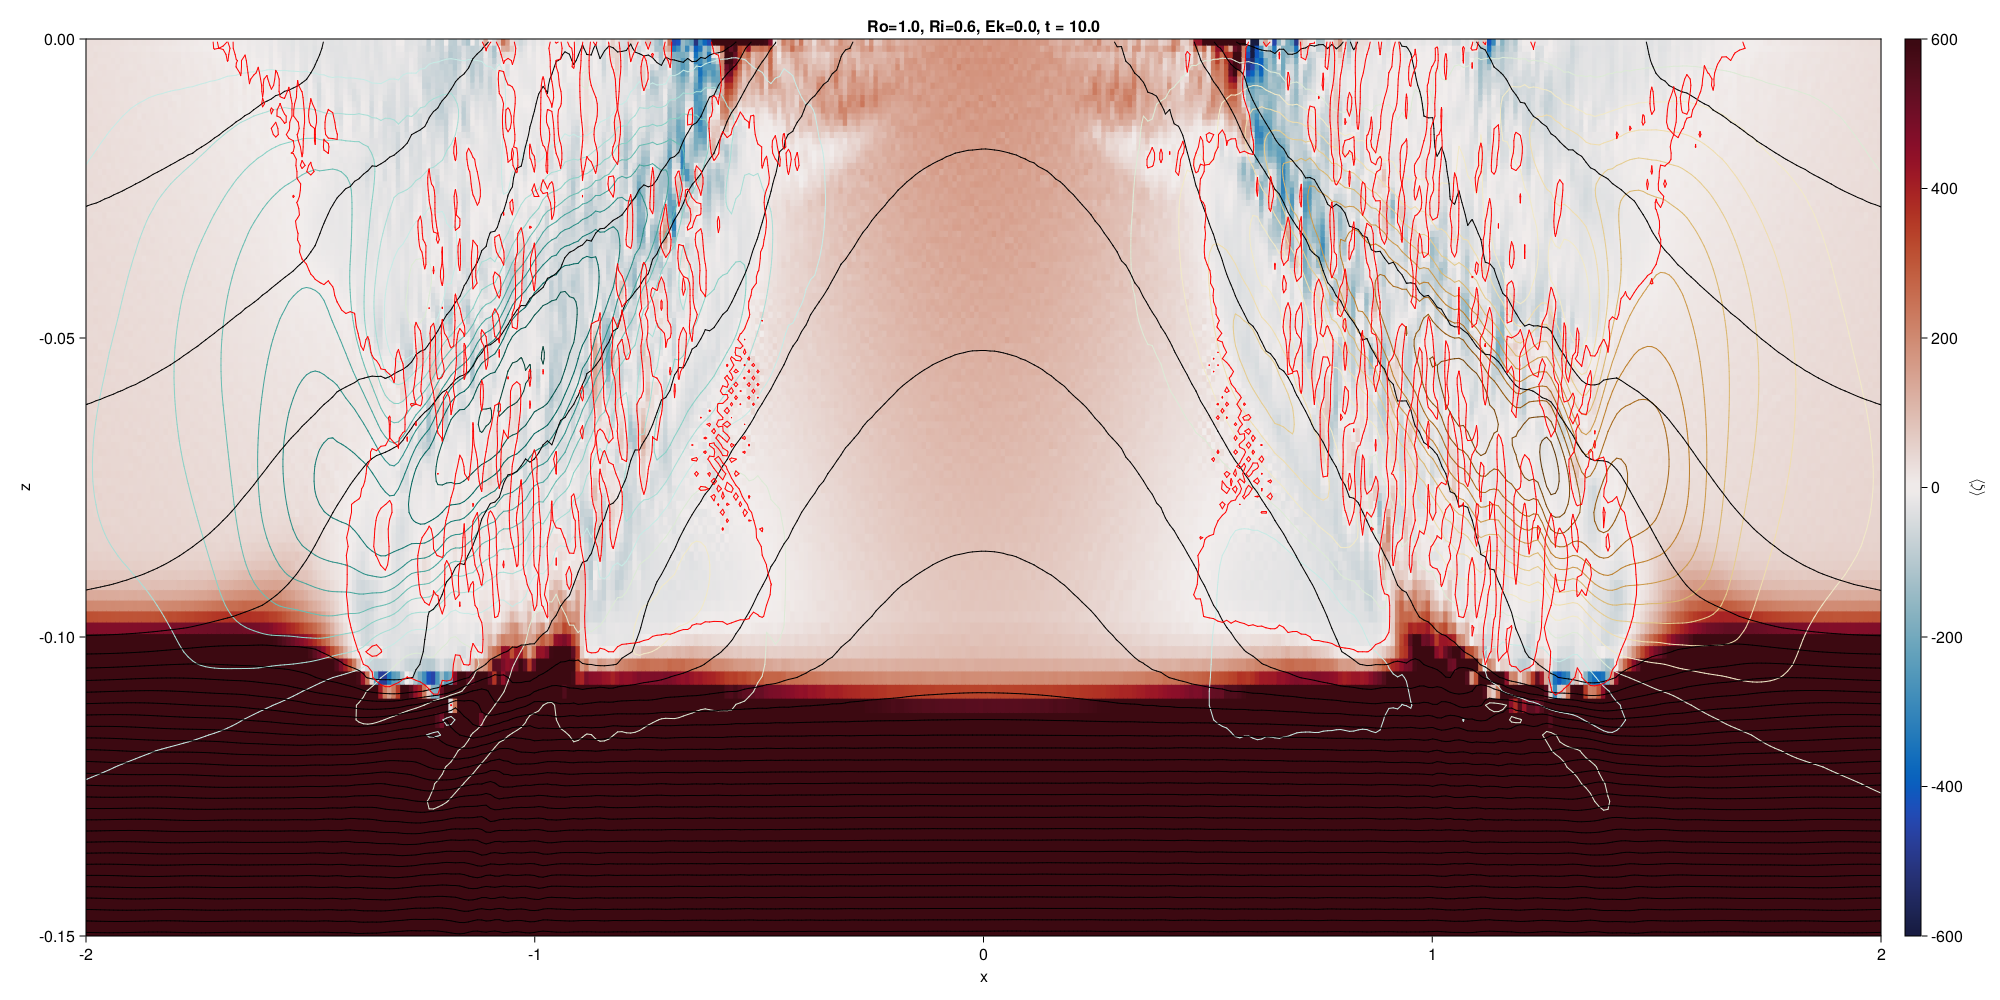

In [5]:
makeqvid("Ro1Ri06Ek0", 1101)

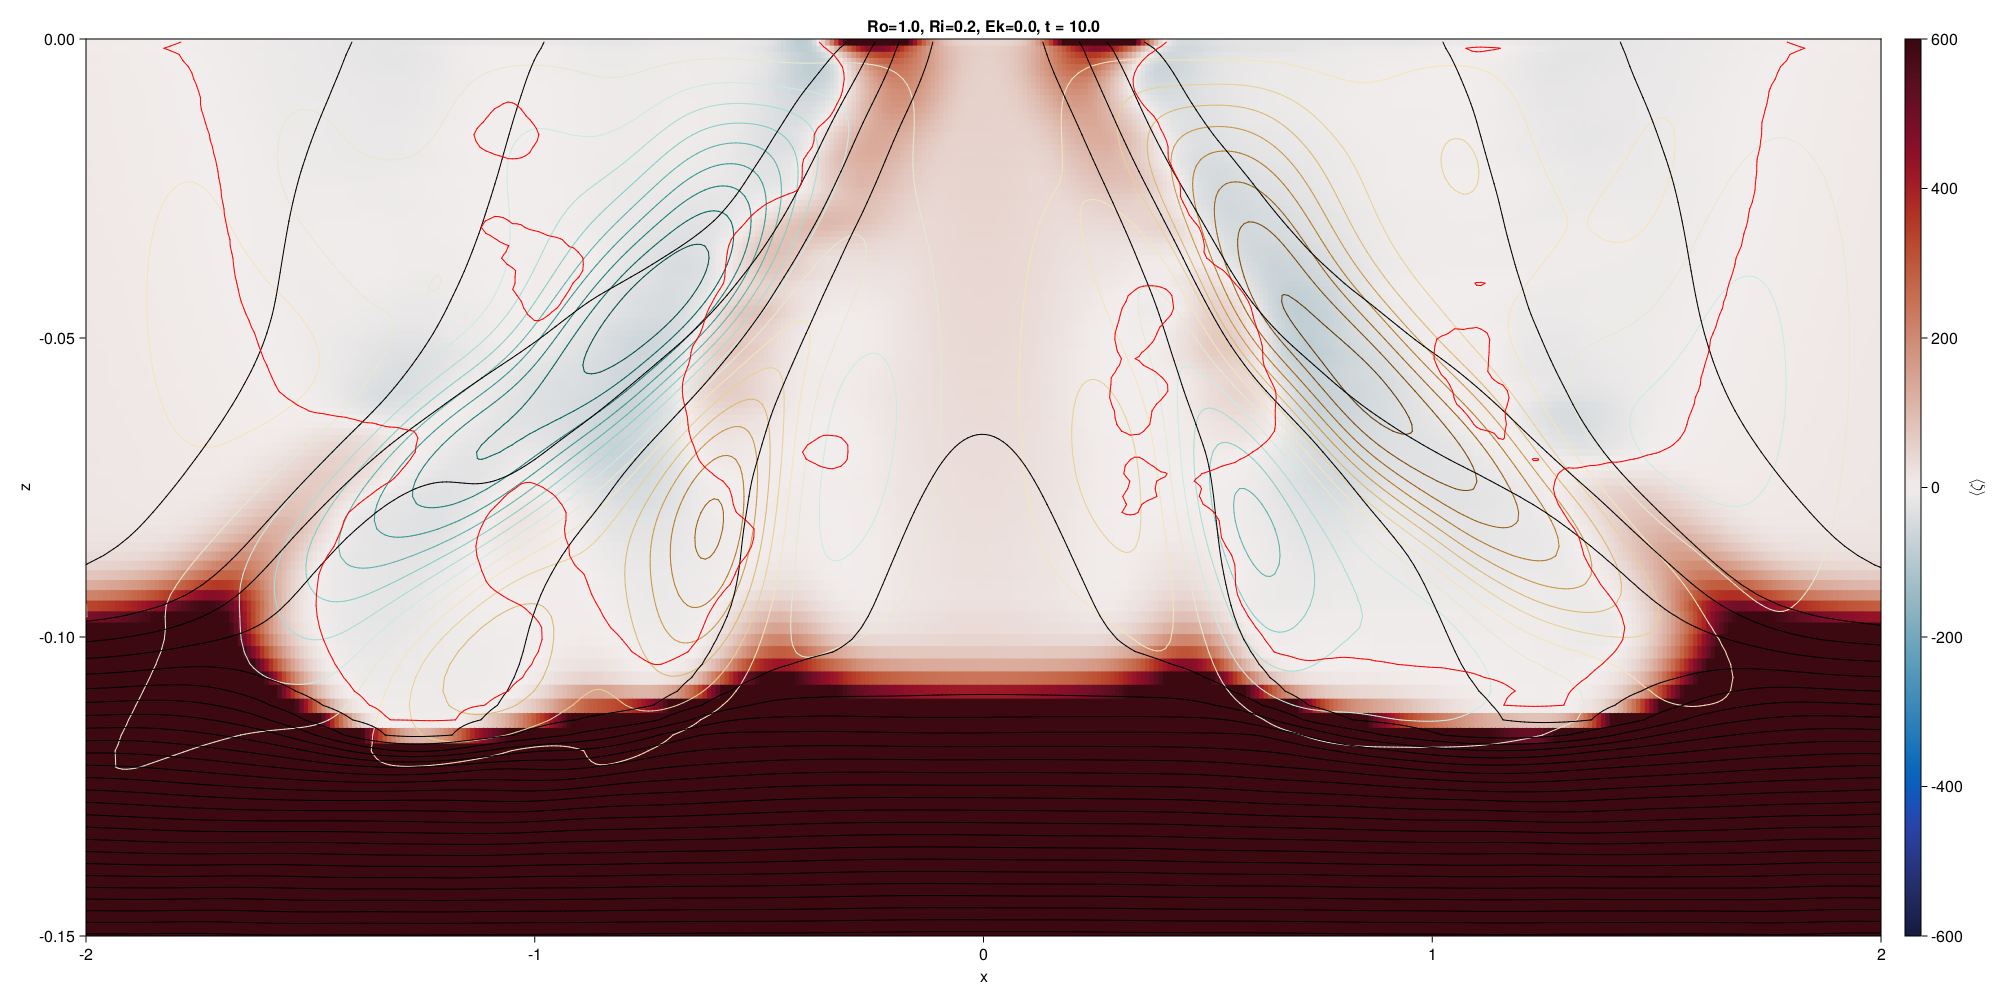

In [35]:
makeqvid("Ro1Ri02Ek0",1101)